In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb

In [2]:
df = pd.read_csv('sales_data.csv')
df.head()

,InvoiceNo,InvoiceDate,Customer ID,Gender,Age,Product Category,Quantity,UnitPrice,Total Amount
0,1,24-11-2023,CUST001,Male,34,Beauty,3,50,150
1,2,27-02-2023,CUST002,Female,26,Clothing,2,500,1000
2,3,13-01-2023,CUST003,Male,50,Electronics,1,30,30
3,4,21-05-2023,CUST004,Male,37,Clothing,1,500,500
4,5,06-05-2023,CUST005,Male,30,Beauty,2,50,100


In [3]:
df.isnull().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InvoiceNo         1000 non-null   int64 
 1   InvoiceDate       1000 non-null   object
 2   Customer ID       1000 non-null   object
 3   Gender            1000 non-null   object
 4   Age               1000 non-null   int64 
 5   Product Category  1000 non-null   object
 6   Quantity          1000 non-null   int64 
 7   UnitPrice         1000 non-null   int64 
 8   Total Amount      1000 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 70.4+ KB


In [10]:
df.dropna(inplace=True)
df = df[df['Quantity'] > 0]
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalPrice': 'sum'
})

rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'Monetary'}, inplace=True)

In [14]:
print(df.columns)

Index(['InvoiceNo', 'InvoiceDate', 'Customer ID', 'Gender', 'Age',
       'Product Category', 'Quantity', 'UnitPrice', 'Total Amount',
       'TotalPrice'],
      dtype='object')


In [16]:
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

In [17]:
X = rfm[['Recency', 'Frequency', 'AOV']]
y = rfm['Monetary']  # Target variable

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [20]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.00012131690891692415
RMSE: 0.000212181752713158


In [21]:
rfm['Predicted_LTV'] = model.predict(X)
rfm['Segment'] = pd.qcut(rfm['Predicted_LTV'], q=4, labels=['Low', 'Medium', 'High', 'VIP'])

In [22]:
rfm.to_csv('Final_LTV_Predictions.csv', index=True)

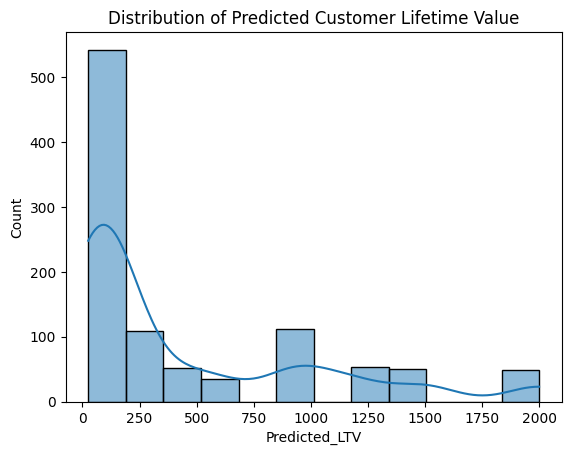

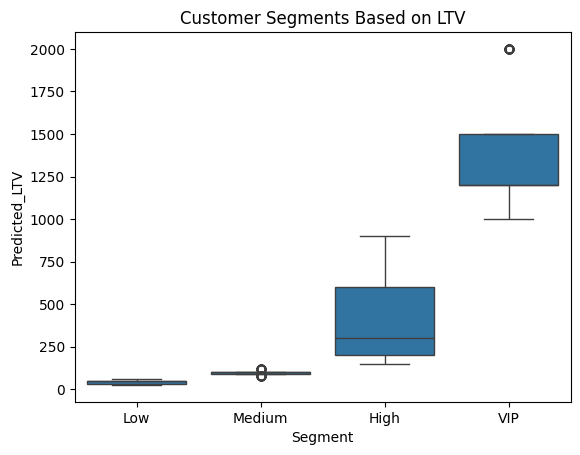

In [23]:
sns.histplot(rfm['Predicted_LTV'], kde=True)
plt.title("Distribution of Predicted Customer Lifetime Value")
plt.show()

sns.boxplot(x='Segment', y='Predicted_LTV', data=rfm)
plt.title("Customer Segments Based on LTV")
plt.show()